In the 'stocks_analysis' notebook we've analysed the stock prices of Apple and GM. Let's try to predict one of these time series.

In [90]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import prophet

Importing plotly failed. Interactive plots will not work.


As a model to train and use for prediction, we will choose something from the autoregressive models. As a dataset, we will choose the closing price of Apple stocks. Since the series is not stationary, it is necessary to choose a model that is robust to this, so my choice is ARIMA.

In [91]:
def get_price_data(ticker):
    ticker_data = yf.Ticker(ticker)
    ticker_df = ticker_data.history(period='1d', start='2017-1-1', end='2022-10-23')
    return ticker_df.iloc[:, 3:4]

In [92]:
def transform_date(df: pd.DataFrame):
    df['index'] = list(range(df.shape[0]))
    df['DateTime'] = df.index
    df = df.set_index('index')
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df

In [93]:
apple = get_price_data('AAPL')

In [94]:
apple = transform_date(apple)

In [95]:
apple.head()

,Close,DateTime
index,,
0,27.219837,2017-01-03 00:00:00-05:00
1,27.189365,2017-01-04 00:00:00-05:00
2,27.327635,2017-01-05 00:00:00-05:00
3,27.632290,2017-01-06 00:00:00-05:00
4,27.885389,2017-01-09 00:00:00-05:00


In [96]:
N_test = 365

In [97]:
train = apple.iloc[:-N_test]
test = apple.iloc[-N_test:]

In [98]:
model = pm.auto_arima(train['Close'],
                      trace=True,
                      suppress_warnings=True,
                      seasonal=False,
                      # start_p=10,
                      # start_q=10,
                      # max_p=50,
                      # max_q=50,
                      # d=1,
                      # max_d=30
                      )

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4034.994, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4044.176, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4030.225, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4031.283, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4045.673, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4031.203, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4031.011, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4033.010, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4032.693, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.457 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1097
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2012.112
Date:                Tue, 25 Oct 2022   AIC                           4030.225
Time:                        17:56:58   BIC                           4045.223
Sample:                             0   HQIC                          4035.900
                               - 1097                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0972      0.046      2.113      0.035       0.007       0.187
ar.L1         -0.1204      0.017     -7.164      0.000      -0.153      -0.087
sigma2         2.3021      0.043     54.021      0.000       2.219       2.386
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3487.96
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              24.39   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [99]:
test_predictions, confidence_interval = model.predict(n_periods=N_test, return_conf_int=True)

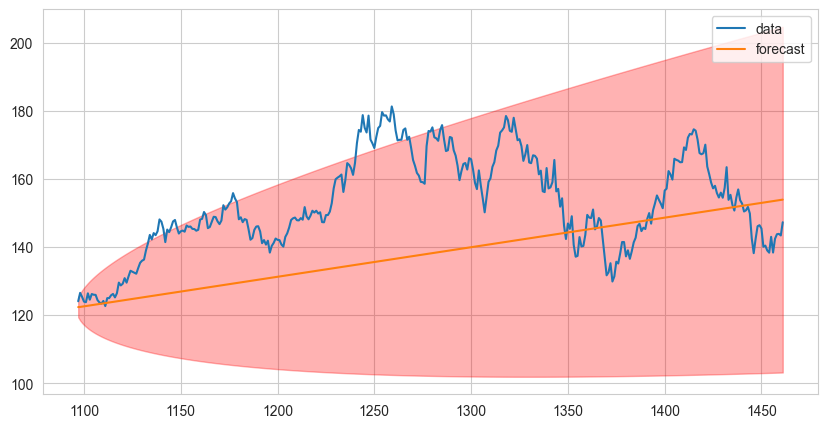

In [100]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test.index, test['Close'], label='data')
ax.plot(test.index, test_predictions, label='forecast')
ax.fill_between(test.index, confidence_interval[:,0], confidence_interval[:, 1], color='red', alpha=0.3)
ax.legend();

In [101]:
def rmse(t, y):
    return np.sqrt(np.mean((t-y)**2))

def mape(t, y):
    return np.mean(np.abs((t - y) / t)) * 100

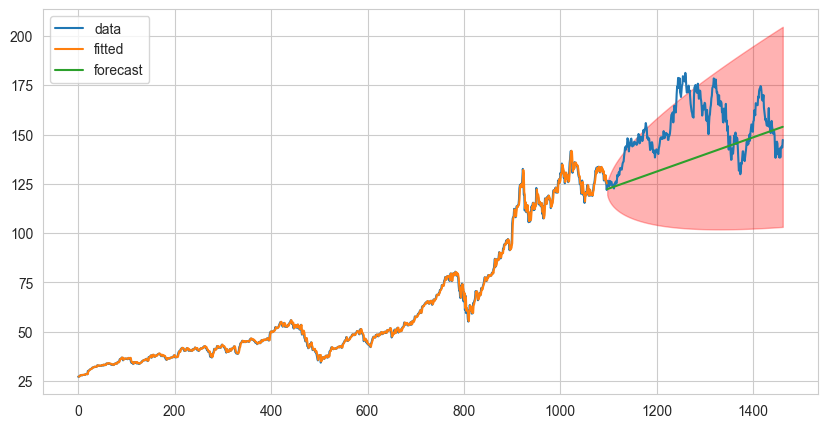

In [102]:
train_predictions = model.predict_in_sample(start=1, end=-1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(apple.index, apple['Close'], label='data')
ax.plot(train.index[1:], train_predictions, label='fitted')
ax.plot(test.index, test_predictions, label='forecast')
ax.fill_between(test.index, confidence_interval[:,0], confidence_interval[:, 1], color='red', alpha=0.3)
ax.legend();

In [103]:
rmse(test['Close'], test_predictions)

20.072395615502128

In [104]:
mape(test['Close'], test_predictions)

10.54299611782586

Mape = 10%, overall a decent result, the prediction intervals are not the largest and almost all real observations fall into it, however, it worries me that the model essentially predicts the trend, it may be explained as follows: the variance is extremely variable and over time it only increases, building MA on the errors of the autoregression does not make sense, because we cannot approximate them in any way due to the variable variance (even after differentiation, the series is weakly similar to stationary [tried as in task 1 boxcox, but the result on the same model (auto_arima) turned out to be worse and the intervals twice as wide]), so q=0. However, the step of this series is day and maybe it makes sense to try a model capable of considering the relationship also by weeks (of course, we're talking about facebook prophet [I don't really like predict in the form of a straight line]).

In [119]:
apple['ds'] = apple['DateTime'].dt.date

In [120]:
new_apple = apple.copy()

In [121]:
new_apple.rename(columns={'Close': 'y'}, inplace=True)

In [124]:
new_apple = new_apple[['ds', 'y']]

In [125]:
new_train = new_apple.iloc[:-N_test]
new_test = new_apple.iloc[-N_test:]

In [127]:
new_train

,ds,y
index,,
0,2017-01-03,27.219837
1,2017-01-04,27.189365
2,2017-01-05,27.327635
3,2017-01-06,27.632290
4,2017-01-09,27.885389
...,...,...
1092,2021-05-06,128.605606
1093,2021-05-07,129.290726
1094,2021-05-10,125.954437


In [143]:
m = prophet.Prophet()

In [144]:
m.fit(new_train)

18:08:56 - cmdstanpy - INFO - Chain [1] start processing
18:08:56 - cmdstanpy - INFO - Chain [1] done processing


In [145]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1457,2022-05-08
1458,2022-05-09
1459,2022-05-10
1460,2022-05-11
1461,2022-05-12


In [146]:
forecast = m.predict(future)

In [147]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1457,2022-05-08,189.658828,165.360445,213.459209
1458,2022-05-09,190.782590,167.070964,214.476188
1459,2022-05-10,191.132103,166.779324,214.509202
1460,2022-05-11,191.316534,167.653589,214.936495
1461,2022-05-12,191.538498,168.403483,214.883862


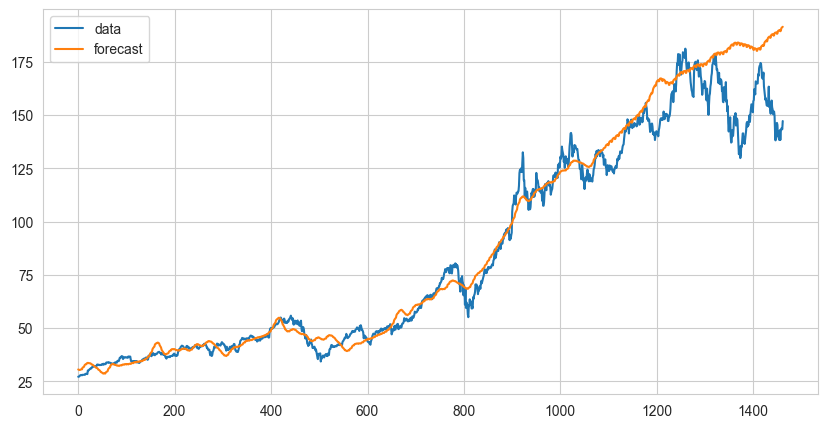

In [148]:
train_predictions = model.predict_in_sample(start=1, end=-1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(apple.index, apple['Close'], label='data')
# ax.plot(train.index[1:], train_predictions, label='fitted')
ax.plot(apple.index, forecast['yhat'], label='forecast')
# ax.fill_between(test.index, confidence_interval[:,0], confidence_interval[:, 1], color='red', alpha=0.3)
ax.legend();

In [149]:
mape(forecast['yhat'][forecast.shape[0]-N_test:], test['Close'])

9.867693886471601

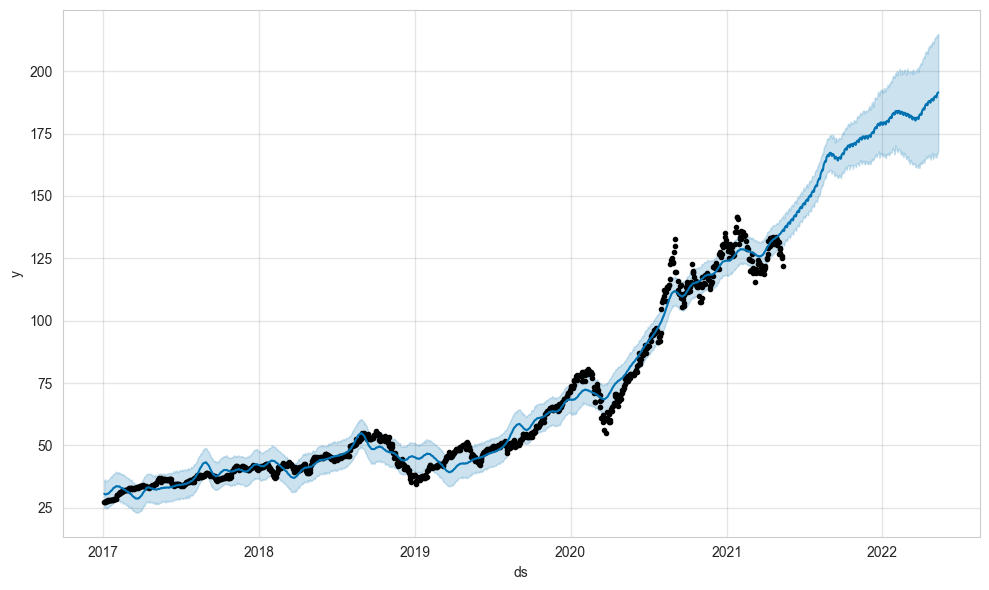

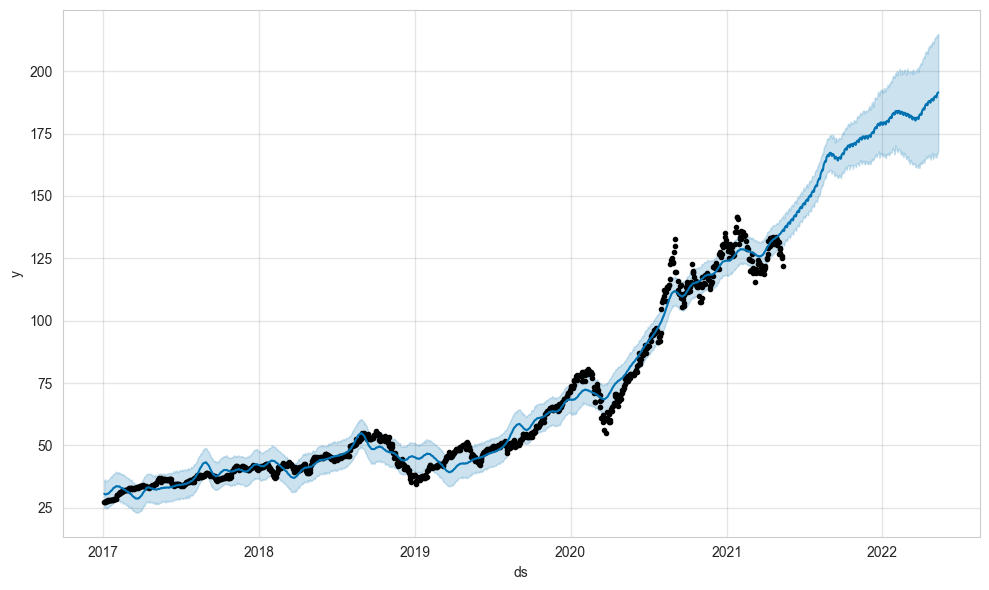

In [150]:
m.plot(forecast)

The metric is slightly better than ARIMA, the prediction is not linear and the model attempted to predict the nonlinear behavior of the series, however, the result is almost the same and the range of confidence intervals is the same. Moreover, the values in 2021 began to decrease, but the model continued the series as growing. The matter is most likely in the extreme unpredictability of this series and the fact that we are trying to make predictions for a year in advance, and such chaotic systems on such a large time frame can give extremely unpredictable results (like the black swans).